# Classical Job Shop Scheduling Problem (JSSP)

This notebook demonstrates the formulation and solution of the classical Job Shop Scheduling Problem (JSSP) using Python and optimization libraries. The JSSP is a fundamental problem in combinatorial optimization and production scheduling.

## Problem Description and Mathematical Formulation

The classical Job Shop Scheduling Problem (JSSP) consists of scheduling a set of jobs, each with a fixed sequence of operations, on a set of machines. Each operation must be processed on a specific machine for a given duration, and each machine can process at most one operation at a time. The objective is to minimize the makespan (the total completion time).

**Sets and Parameters:**
- $J$: set of jobs
- $M$: set of machines
- $O_j$: ordered set of operations for job $j$
- $p_{j,o}$: processing time of operation $o$ of job $j$
- $m_{j,o}$: machine required for operation $o$ of job $j$

**Decision Variables:**
- $S_{j,o}$: start time of operation $o$ of job $j$
- $C_{max}$: makespan

**Model:**

\begin{align*}
\text{Minimize} \quad & C_{max} \\
\text{subject to:} \quad
& S_{j,o+1} \geq S_{j,o} + p_{j,o} && \forall j \in J, \forall o < |O_j| \\
& S_{j',o'} \geq S_{j,o} + p_{j,o} \quad \text{or} \quad S_{j,o} \geq S_{j',o'} + p_{j',o'} && \forall (j,o) \neq (j',o') \text{ on same machine} \\
& C_{max} \geq S_{j,|O_j|} + p_{j,|O_j|} && \forall j \in J
\end{align*}


## Data Input

Read the job shop instance from a CSV file. The file should contain columns: `job`, `machine`, `processing_time`, and `order` (the sequence of operations for each job).

In [11]:
import pandas as pd

# Read the CSV file (update the filename as needed)
df = pd.read_csv('jobshop_instance.csv')

grouped = df.groupby('job')
jobs = {}
for job, group in grouped:
    # Each job: list of (machine, processing_time) in order
    jobs[job] = list(zip(group.sort_values('order')['machine'], group.sort_values('order')['processing_time']))
machines = sorted(df['machine'].unique())

print('Jobs:', jobs)
print('Machines:', machines)
df.head()

Jobs: {0: [(0, 3), (1, 6)], 1: [(0, 5), (1, 2)], 2: [(0, 4), (1, 3)]}
Machines: [np.int64(0), np.int64(1)]


,job,machine,processing_time,order
0,0,0,3,0
1,0,1,6,1
2,1,0,5,0
3,1,1,2,1
4,2,0,4,0


## Model Definition and Optimization

Formulate and solve the classical job shop scheduling problem as a mixed-integer programming model using PuLP.

In [12]:
import pulp
from itertools import product

# Create the model
model = pulp.LpProblem('ClassicalJSSP', pulp.LpMinimize)

# Decision variables: start time for each operation (job, op_idx)
start = {}
for job in jobs:
    for op_idx, (machine, ptime) in enumerate(jobs[job]):
        start[(job, op_idx)] = pulp.LpVariable(f'start_{job}_{op_idx}', lowBound=0)

# Makespan variable
makespan = pulp.LpVariable('makespan', lowBound=0)
model += makespan

# Precedence constraints (operations within a job)
for job in jobs:
    for op_idx in range(len(jobs[job]) - 1):
        model += start[(job, op_idx+1)] >= start[(job, op_idx)] + jobs[job][op_idx][1]

# Machine constraints (no overlap on the same machine)
for machine in machines:
    ops = [(job, op_idx, jobs[job][op_idx][1])
           for job in jobs for op_idx, (m, _) in enumerate(jobs[job]) if m == machine]
    for (j1, o1, p1), (j2, o2, p2) in product(ops, ops):
        if (j1, o1) < (j2, o2):
            y = pulp.LpVariable(f'y_{j1}_{o1}_{j2}_{o2}', cat='Binary')
            model += start[(j1, o1)] + p1 <= start[(j2, o2)] + (1 - y) * 1e5
            model += start[(j2, o2)] + p2 <= start[(j1, o1)] + y * 1e5

# Makespan constraints
for job in jobs:
    last_op = len(jobs[job]) - 1
    model += makespan >= start[(job, last_op)] + jobs[job][last_op][1]

# Solve the model
model.solve()
print('Objective value (makespan):', pulp.value(makespan))
print('Status:', pulp.LpStatus[model.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/mr/zqfbkrv54kq4075qzk378c580000gn/T/dfa8f060eae8410c86464f79bf64c6b4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/mr/zqfbkrv54kq4075qzk378c580000gn/T/dfa8f060eae8410c86464f79bf64c6b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 23 COLUMNS
At line 85 RHS
At line 104 BOUNDS
At line 111 ENDATA
Problem MODEL has 18 rows, 13 columns and 48 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9 - 0.00 seconds
Cgl0004I processed model has 18 rows, 13 columns (6 integer (6 of which binary)) and 48 elements
Cbc0038I Initial state - 6 integers unsatisfied sum - 0.00023
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 18 iterations 6
Cbc0038I

## Solution Extraction and Visualization

Extract the optimal schedule and visualize it as a Gantt chart.

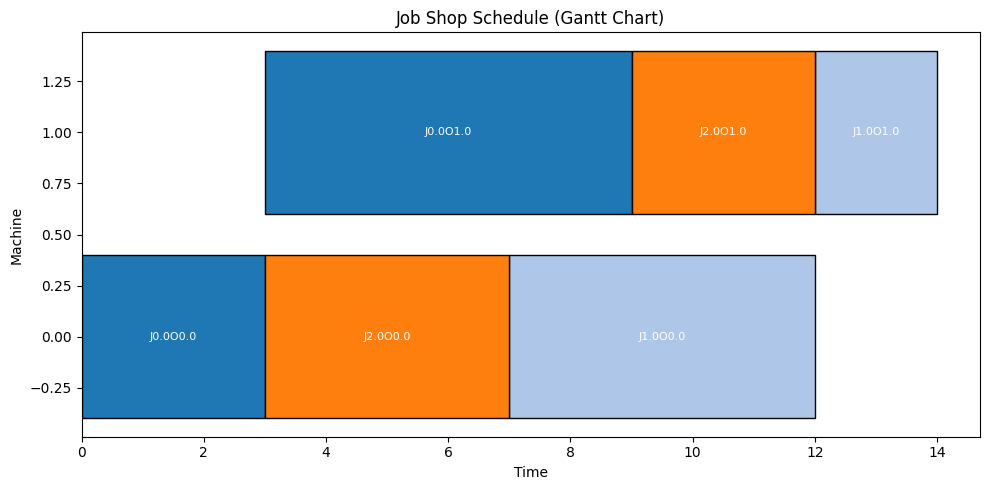

In [14]:
import matplotlib.pyplot as plt

# Extract the schedule
schedule = []
for job in jobs:
    for op_idx, (machine, ptime) in enumerate(jobs[job]):
        st = pulp.value(start[(job, op_idx)])
        schedule.append({
            'Job': job,
            'Operation': op_idx,
            'Machine': machine,
            'Start': st,
            'Finish': st + ptime
        })
schedule_df = pd.DataFrame(schedule)

# Plot Gantt chart
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.tab20.colors
for i, row in schedule_df.iterrows():
    ax.barh(row['Machine'], row['Finish'] - row['Start'], left=row['Start'], color=colors[int(row['Job']) % len(colors)], edgecolor='black')
    ax.text(row['Start'] + (row['Finish'] - row['Start'])/2, row['Machine'], f"J{row['Job']}O{row['Operation']}", va='center', ha='center', color='white', fontsize=8)
ax.set_xlabel('Time')
ax.set_ylabel('Machine')
ax.set_title('Job Shop Schedule (Gantt Chart)')
plt.tight_layout()
plt.show()